# Retail Sales Forecasting - 5 of 5

## Facebook Prophet

Facebook created Prophet with the goal of making it easier to generate high quality time series forecasts. Let's see how it performs on this daily sales data set.

### Notebook Setup

In [1]:
%matplotlib inline

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# Import Pandas, Matplotlib, etc
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

# Homegrown utilities for making lags, back testing, etc.
from lag_transformer import LagTransformer
from back_test import walk_forward_validate, calc_metrics, get_first_sunday

plt.style.use('ggplot')

DAYS_IN_WEEK = 7
MIN_TRAIN_SIZE = DAYS_IN_WEEK * 20

## Load & Transform for Prophet

In [2]:
df_in = pd.read_excel('../data/daily-sales.xlsx')

df = df_in[['date', 'sales']].copy()
df.columns = ['ds', 'y']

# Need to do this to make the log transform work
df['y'] = df['y'].replace(0.0, 0.10)

# Prophet expects a stationary time series. You can do this through a Box Jenkins transform, differencing
# or get pretty close by just taking the log of 'y'.
df['y_orig'] = df['y']
df['y'] = np.log(df['y'])

df.head(10)

,ds,y,y_orig
0,2017-11-17,5.854011,348.63
1,2017-11-18,7.196222,1334.38
2,2017-11-19,-2.302585,0.10
3,2017-11-20,6.238481,512.08
4,2017-11-21,-2.302585,0.10
5,2017-11-22,7.032015,1132.31
6,2017-11-23,-2.302585,0.10
7,2017-11-24,7.835789,2529.53
8,2017-11-25,7.343271,1545.76
9,2017-11-26,6.108047,449.46


### Generate a Prophet Forecast

In [3]:
model = Prophet()
model.fit(df)

df_pred = model.make_future_dataframe(periods=DAYS_IN_WEEK)
df_pred = model.predict(df_pred)

# Reverse the log transform for y and yhat
df_plot = df_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_plot['yhat'] = np.exp(df_pred['yhat'])
df_plot['y'] = np.exp(df['y'])
df_plot.dropna(inplace=True)
df_plot = df_plot.set_index(pd.to_datetime(df_plot.ds))
df_plot.head(12)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper,y
ds,,,,,
2017-11-17,2017-11-17,409.626054,3.351337,8.502948,348.63
2017-11-18,2017-11-18,669.161748,3.863798,9.157969,1334.38
2017-11-19,2017-11-19,0.173109,-4.471604,0.734974,0.10
2017-11-20,2017-11-20,184.810776,2.468850,7.568539,512.08
2017-11-21,2017-11-21,211.954308,2.842726,7.971755,0.10
2017-11-22,2017-11-22,286.938580,2.899269,8.317670,1132.31
2017-11-23,2017-11-23,222.102323,2.889302,7.872939,0.10
2017-11-24,2017-11-24,416.348960,3.446808,8.583238,2529.53
2017-11-25,2017-11-25,680.144232,4.000752,9.198265,1545.76


### Plot the Result

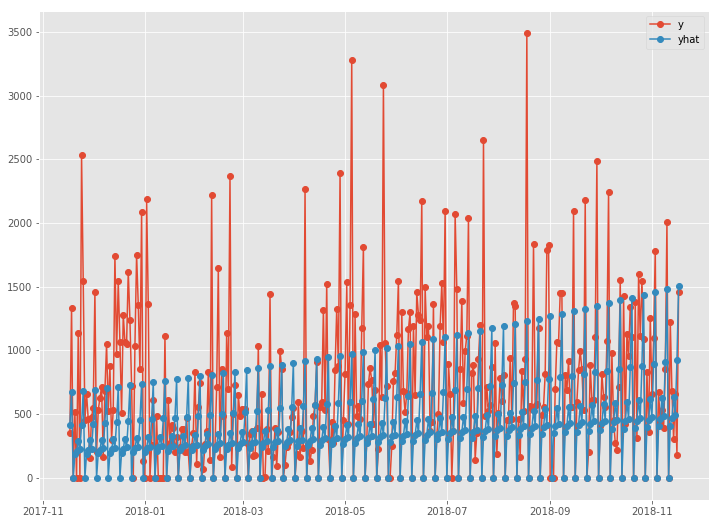

In [4]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(df_plot.y, marker='o')
plt.plot(df_plot.yhat, marker='o')
plt.legend()
plt.show()


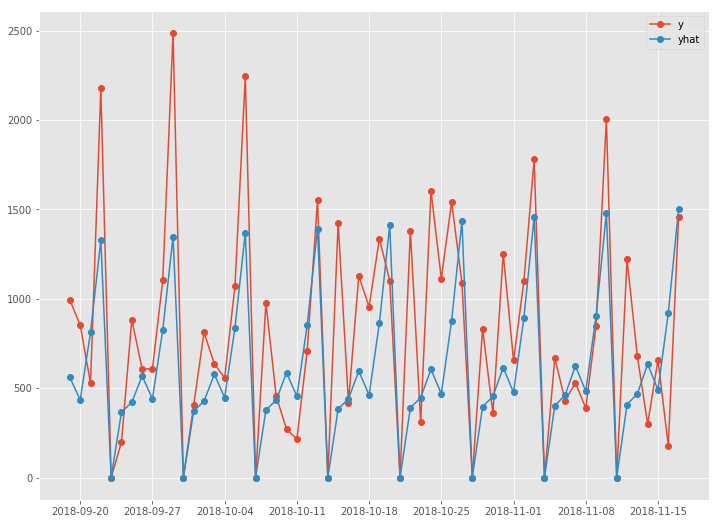

In [5]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(df_plot.y[-60:], marker='o')
plt.plot(df_plot.yhat[-60:], marker='o')
plt.legend()
plt.show()

### Back Test Prophet

Use the cross validation function that comes with Prophet to generate weekly forcasts over a range of dates. See the code comments on how to properly set the horizon, period and initial parameters illustrated in the figure below. It's not entirely clear how to do this from the documentation and required a read of the cross_validation code. 

![diagnostics_3_0.png](images/diagnostics_3_0.png)

In [6]:
# With all of the cross_validation parameters, you need to specify the unit along with the
# value as a string. ie 7 days or 12 hours
# 
# Period - The number and type of periods to forecast. (7 days in this case)
# Initial - Size of the initial training data (16 weeks in this case). Specified FROM THE BEGINNING of the data.
# Horizon - Number of days to leave off from the end of the data. This is specified FROM THE END of the data.
#
# Horizon = End of data (ie len(df.index)) - Horizon
# Cutoff = Horizon - Period
# At each cross validation iteration, Cutoff is decremented by Period until Initial is reached. 

horizon = '{} days'.format(DAYS_IN_WEEK)
period = '{} days'.format(DAYS_IN_WEEK)
initial = '{} days'.format(MIN_TRAIN_SIZE)

# NOTE - This will take a while so be patient
df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
df_cv['y'] = np.exp(df_cv['y'])
df_cv['yhat'] = np.exp(df_cv['yhat'])

df_cv.tail(12)

INFO:fbprophet.diagnostics:Making 32 forecasts with cutoffs between 2018-04-07 00:00:00 and 2018-11-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
212,2018-11-06,461.390459,3.571970,8.931447,431.19,2018-11-03
213,2018-11-07,639.797491,3.819879,9.051454,531.03,2018-11-03
214,2018-11-08,485.473734,3.425072,8.789118,388.11,2018-11-03
215,2018-11-09,942.194907,4.315440,9.476072,849.25,2018-11-03
216,2018-11-10,1479.900109,4.632412,9.995034,2007.19,2018-11-03
217,2018-11-11,0.415497,-3.429910,1.762836,0.10,2018-11-10
218,2018-11-12,413.823591,3.177092,8.466365,1220.64,2018-11-10
219,2018-11-13,480.975998,3.651073,8.796781,678.82,2018-11-10
220,2018-11-14,664.665204,4.007327,9.107861,300.02,2018-11-10
221,2018-11-15,504.284181,3.662739,8.810222,658.48,2018-11-10


In [7]:
df_m = calc_metrics(df_cv)
df_m.tail(10)

,MAPE,RMSE
date,,
2018-09-09,34.336211,432.024685
2018-09-16,39.745931,495.736924
2018-09-23,42.069091,566.131879
2018-09-30,33.011203,401.675024
2018-10-07,2.656744,295.691241
2018-10-14,36.099165,542.160704
2018-10-21,43.283882,672.238260
2018-10-28,30.954347,357.592450
2018-11-04,9.745214,234.796472


In [8]:
print('MAPE for {:d} week steps = {:.2f}%'.format(len(df_m), df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(len(df_m), df_m['RMSE'].mean()))

MAPE for 32 week steps = 36.57%
RMSE for 32 week steps = 572.01


### Conclusion

Prophet does not perform well on this data set with default parameters. The primary reason is likely due to the week-over-week growth that Prophet is attempting to model. You can see this in the annual forecast plot above. There might be a way to tune Prophet for better performance but doing so will require more time reading through Prophet code than is available for this project.